In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use('science')
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 16 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
cap = [10] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23],
       [6.11, 5.23, 4.27, 6.66, 5.21, 3.72, 7.83, 5.64, 7.56, 3.28, 4.31,
        3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68]])

## Optimization Model 

In [5]:
#ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver='gurobi')
ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver='glpk')

Solver in the background: glpk


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Obj: 18.0
5
13


In [7]:
# relax
ks_model_rel = ks_model.relax()

Solver in the background: glpk


In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75825065494684, 0.0, 0.913521784638344, 0.421842880409434, 0.0]
Obj: 26.12234073044579
11
13
14


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.10it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.13it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.08it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 16])

In [18]:
w.shape

torch.Size([32, 16])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [22]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [23]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [24]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [25]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.03it/s]


Normalized true SPO Loss: 2.01%
Normalized unambiguous SPO Loss: 2.01%


In [26]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 9.00, 3.00, 7.00, 3.00, 4.00, 4.00, 5.00, 3.00, 2.00, 6.00, 7.00, 3.00, 4.00, 2.00, 4.00, 2.00
    Pred cost: 8.42, 3.70, 6.85, 4.64, 4.61, 4.61, 6.97, 3.00, 2.97, 6.70, 6.85, 4.86, 4.61, 3.13, 4.28, 2.97
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 13.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 5.00, 2.00, 5.00, 4.00, 4.00, 4.00, 3.00, 3.00, 2.00, 3.00, 5.00, 1.00, 4.00, 2.00, 2.00, 2.00
    Pred cost: 6.09, 1.42, 5.24, 4.79, 4.39, 4.39, 4.58, 3.00, 2.48, 3.68, 5.24, 0.58, 4.39, 2.94, 2.81, 2.48
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 9.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 9.00

Sample 2:
    True cost: 21.00, 3.00, 10.00, 9.00, 9.00, 9.00, 13.00, 3.00, 4.00, 11.00, 10.00, 8.00, 9.00, 5.00, 9.00, 4.00
    Pred cost: 13.13, 3.23, 8.72, 9.15, 7.64, 7.64, 11.83, 3.00, 5.28, 9.20, 8.72, 8.83, 7.64, 6.22, 7.

## Linear Regression from PyTorch

In [27]:
from torch import nn

In [28]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [29]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [30]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [31]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [32]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   8.8557, True SPO Loss: 19.4759%, Unambiguous SPO Loss: 19.4759%
Epoch  20, Loss:   4.0390, True SPO Loss:  5.3291%, Unambiguous SPO Loss:  5.3291%
Epoch  30, Loss:   3.0701, True SPO Loss:  2.0335%, Unambiguous SPO Loss:  2.0335%
Epoch  40, Loss:   0.7940, True SPO Loss:  0.9116%, Unambiguous SPO Loss:  0.9116%
Epoch  50, Loss:   1.2290, True SPO Loss:  0.6311%, Unambiguous SPO Loss:  0.6311%
Epoch  60, Loss:   3.6109, True SPO Loss:  0.5610%, Unambiguous SPO Loss:  0.5610%
Epoch  70, Loss:   0.7329, True SPO Loss:  0.5522%, Unambiguous SPO Loss:  0.5522%
Epoch  80, Loss:   0.3039, True SPO Loss:  0.3944%, Unambiguous SPO Loss:  0.3944%
Epoch  90, Loss:   0.4530, True SPO Loss:  0.2279%, Unambiguous SPO Loss:  0.2279%
Epoch 100, Loss:   0.5726, True SPO Loss:  0.3331%, Unambiguous SPO Loss:  0.3331%
Epoch 110, Loss:   0.1547, True SPO Loss:  0.2892%, Unambiguous SPO Loss:  0.2892%
Epoch 120, Loss:   0.1395, True SPO Loss:  0.4207%, Unambiguous SPO Loss:  0.4207%
Epoc

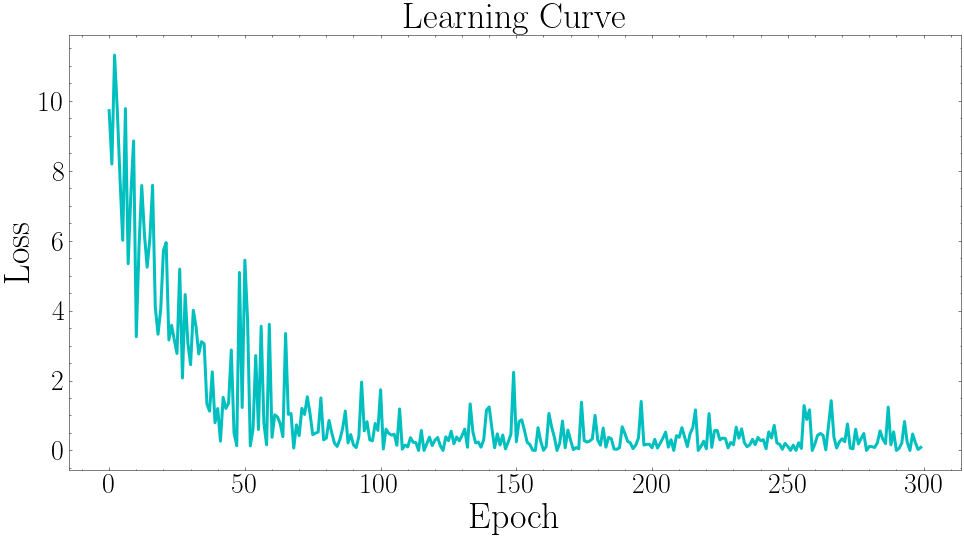

In [33]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color='c', lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.show()

In [ ]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=3, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=3, label='Unambiguous Regret')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [ ]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

In [ ]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

## SPO+ Rel 

In [ ]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [ ]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [ ]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model_rel, processes=4)

In [ ]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

In [ ]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color='c', lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.show()

In [ ]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=3, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=3, label='Unambiguous Regret')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [ ]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

In [ ]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

## Black-Box

In [ ]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [ ]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [ ]:
# set loss
bb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

In [ ]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

In [ ]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color='c', lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.show()

In [ ]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=3, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=3, label='Unambiguous Regret')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('Epoch', fontsize=36)
plt.ylabel('Loss', fontsize=36)
plt.title('Learning Curve', fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [ ]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

In [ ]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break